In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [116]:
import os
os.chdir("/content/gdrive/MyDrive/house-prices-advanced-regression-techniques")

import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim


# **Pytorch setting**

In [92]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()                 # get the current available device ('cpu' or 'cuda')

In [93]:
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Import data**

In [94]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

In [95]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [96]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [97]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# **Deal with Categorical cols**

In [98]:
# find categorical cols 篩選出類別型態欄位
obj_cols = [i for i in range(len(df_train.columns)-1) if df_train.iloc[:, i].dtype == "O"]
obj_cols

[2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 39,
 40,
 41,
 42,
 53,
 55,
 57,
 58,
 60,
 63,
 64,
 65,
 72,
 73,
 74,
 78,
 79]

In [99]:
# non-ordinal categorical feature cols 無序類別：
non_ordinal_col = [2, 5, 6, 8, 10, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 29, 39, 41, 42, 55, 58, 74, 78, 79]
# ordinal categorical feature cols 有序類別：
ordinal_col = [7, 9, 11, 27, 28, 30, 31, 32, 33, 35, 40, 53, 57, 60, 63, 64, 65, 72, 73]

In [100]:
# read data_description.txt
with open("./data_description.txt") as f:
  description = f.readlines()

# find the position(row) of feature names 抓出欄位名稱所在行數
cols_title = [i for i,j in enumerate(description) if not bool(j.startswith(" ")) and not bool(j.startswith("\n")) and not bool(j.startswith("\t"))]

# record the beginning and the end position(row) of each feature 紀錄每個欄位描述的起始與截止行數
position = []
for i in range(len(cols_title)):
  if i == len(cols_title)-1:
    POB = cols_title[i]
    POE = len(description)
  else:
    POB = cols_title[i]
    POE = cols_title[i+1]

  position.append((POB, POE))

# odirnal categorical cols

In [101]:
def ordinal_cat_transfer(description, position, df, col_ind):

    # ordinal mapping
    ordinal_dict = {}
    for i in range(len(position)):
      if i+1 in col_ind:
        ranking = {}
        POB, POE = position[i][0], position[i][1]
        count = 1

        for line in description[POB: POE]:
          if line.startswith(" "):
            cls = line.split("\t")[0].replace(" ", "")

            if cls == "NA":
              rank = -1
            else:
              rank = count

            ranking.update({
                line.split("\t")[0].replace(" ", ""): rank
                })
            count+=1

        ordinal_dict.update({
            i+1: ranking
        })

    # ordinal encoding

    for i in col_ind:
        df.iloc[:, i] = df.iloc[:, i].apply(lambda x: ordinal_dict.get(i).get(x))

    df.iloc[:, col_ind] = df.iloc[:, col_ind].fillna(df.iloc[:, col_ind].mean())
    encoded_data = df.iloc[:, col_ind].apply(lambda x: pd.to_numeric(x)).to_numpy()

    print(encoded_data.shape)

    return encoded_data

ord_encoded_data = ordinal_cat_transfer(description, position, df_train.copy(), ordinal_col)


(1460, 19)


# non-odirnal categorical cols




In [102]:
def non_ordinal_cat_transfer(description, position, df, col_ind):

    row_data = df.iloc[:, col_ind].fillna("nan").to_numpy()

    # non_ordinal mapping
    label_lst = []
    for i in range(len(position)):
      if i+1 in col_ind:
        classes = []
        POB, POE = position[i][0], position[i][1]
        label_lst.append([line.split("\t")[0].replace(" ", "") for line in description[POB: POE] if line.startswith(" ")])

    # create an array to save encoded data
    encoded_arr = np.empty((row_data.shape[0], 0))

    for i in range(row_data.shape[1]):
        # create OneHotEncoder for each feature
        encoder = OneHotEncoder(categories=[label_lst[i]+["nan"]] ,drop='first')

        # replace feature name to match the name in data_description.txt
        column_data = row_data[:, i].reshape(-1, 1)
        # for col:0 MSZoning
        column_data[column_data == "C (all)"] = "C"
        # for col:5 Neighborhood
        column_data[column_data == "NAmes"] = "Names"
        # for col:8 BldgType
        column_data[column_data == "Duplex"] = "Duplx"
        column_data[column_data == "2fmCon"] = "2FmCon"
        column_data[column_data == "Twnhs"] = "TwnhsI"
        # for col:12 Exterior1st
        column_data[column_data == "Wd Sdng"] = "WdSdng"
        # for col:13 Exterior2nd
        column_data[column_data == "CmentBd"] = "CemntBd"
        column_data[column_data == "Wd Shng"] = "WdSdng"
        column_data[column_data == "Brk Cmn"] = "BrkComm"

        encoded_column = encoder.fit_transform(column_data).toarray()
        # concat encoded data of each col
        encoded_arr = np.concatenate((encoded_arr, encoded_column), axis=1)
    print(encoded_arr.shape)

    return encoded_arr

non_ord_encoded_data = non_ordinal_cat_transfer(description, position, df_train.copy(), non_ordinal_col)


(1460, 188)


# **Numerical cols**

In [103]:
def numerical_transfer(df, ord_ind, non_ord_ind):
    # remove col: Id and col: SalePrice
    numerical_cols = list(set(list(range(1, len(df.columns)-1))).difference(set(ord_ind+non_ord_ind)))

    data = df.iloc[:, numerical_cols].fillna(df.iloc[:, numerical_cols].mean()).to_numpy()
    print(data.shape)

    return data

numerical_data = numerical_transfer(df_train.copy(), ordinal_col, non_ordinal_col)


(1460, 36)


# **concat data**

In [104]:
def concat_data(num_data, ord_data, non_ord_data):
    data = np.column_stack((num_data, ord_data, non_ord_data))
    return data

input_data = concat_data(numerical_data, ord_encoded_data, non_ord_encoded_data)

In [105]:
input_data.shape

(1460, 243)

# **Create dataset**

In [106]:
data = input_data
col_mean = np.nanmean(data[:, :36], axis=0)
inds = np.where(np.isnan(data))
data[inds] = np.take(col_mean, inds[1])

# label = data[:, 1] + data[:, 0]
label = df_train["SalePrice"].to_numpy()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2, random_state=42)


In [107]:
class HOUSEDataset(Dataset):
    def __init__(self,
                 data,
                 label = None,
                 mode="train",
                 mean = None,
                 std = None
                 ):

        self.mode = mode
        self.data = torch.FloatTensor(data)

        if self.mode != "test":
            self.label = torch.FloatTensor(label).unsqueeze(1)
        else:
            self.label = None

        if self.mode == "val":
            self.data[:, :36] = (self.data[:, :36] - mean)/std

        else:
            self._mean = self.data[:, :36].mean(dim=0, keepdim=True)
            self._std = self.data[:, :36].std(dim=0, keepdim=True)
            self.data[:, :36] = (self.data[:, :36] - self._mean)/self._std
            self.data = self.data

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of HOUSE Dataset ({} samples found, each dim = {})'
              .format(self.mode, len(self.data), self.dim))

    def statsItems(self):
        # val data should be normalized by the mean and the std of training data
        return self._mean, self._std

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


# **Deal with nan & create dataset**

In [235]:
# fillnan of numerical cols with mean
data = input_data
col_mean = np.nanmean(data[:, :36], axis=0)
inds = np.where(np.isnan(data))
data[inds] = np.take(col_mean, inds[1])
label = df_train["SalePrice"].to_numpy()/10000

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2, random_state=42)

# create dataset
tr_set = HOUSEDataset(X_train, y_train, mode = "train")
tr_mean, tr_std = tr_set.statsItems()

val_set = HOUSEDataset(X_val, y_val, mode = "val", mean = tr_mean, std = tr_std)

Finished reading the train set of HOUSE Dataset (1168 samples found, each dim = 243)
Finished reading the val set of HOUSE Dataset (292 samples found, each dim = 243)


# **Set configure**

In [267]:
config = {
    "num_epochs": 4000,
    "l2_lambda": 0.01,
    "early_stop": 200,
    "batch_size": 128,
    "lr": 0.0001,
}

Saving model (epoch =    0, loss = 390.1592, val loss = 397.4826, val rmse = 19.9370)
Saving model (epoch =    1, loss = 389.5758, val loss = 396.9135, val rmse = 19.9227)
Saving model (epoch =    2, loss = 388.9896, val loss = 396.3058, val rmse = 19.9074)
Saving model (epoch =    3, loss = 388.3303, val loss = 395.6070, val rmse = 19.8899)
Saving model (epoch =    4, loss = 387.5811, val loss = 394.8194, val rmse = 19.8701)
Saving model (epoch =    5, loss = 386.7067, val loss = 393.8271, val rmse = 19.8451)
Saving model (epoch =    6, loss = 385.5362, val loss = 392.3992, val rmse = 19.8091)
Saving model (epoch =    7, loss = 383.7642, val loss = 390.0785, val rmse = 19.7504)
Saving model (epoch =    8, loss = 380.7286, val loss = 386.0650, val rmse = 19.6485)
Saving model (epoch =    9, loss = 375.5879, val loss = 379.4421, val rmse = 19.4793)
Saving model (epoch =   10, loss = 367.2341, val loss = 368.7798, val rmse = 19.2036)
Saving model (epoch =   11, loss = 353.7234, val loss 

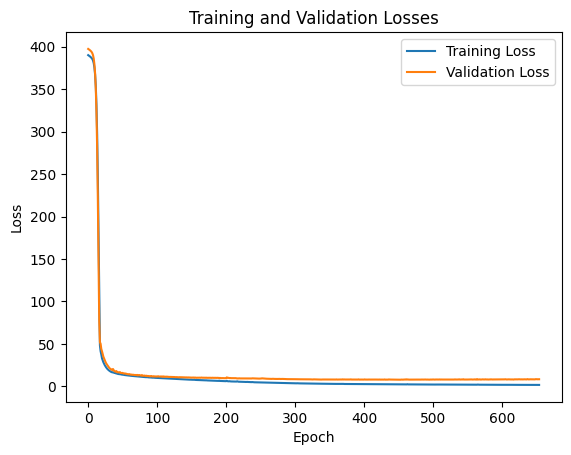

In [268]:
# Set batch of dataset
tr_loader = DataLoader(tr_set, batch_size = config["batch_size"], shuffle=True)
val_loader = DataLoader(val_set, batch_size = config["batch_size"])

# Define the neural network model
class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 64)
        self.linear_hidden = nn.Linear(64, 64)
        self.linear2 = nn.Linear(64, output_size)

        self.ReLU = nn.ReLU()
        self.Softplus = nn.Softplus()

    def forward(self, x):
        x = self.linear(x)
        x = self.ReLU(x)
        x = self.linear_hidden(x)
        x = self.ReLU(x)
        x = self.linear_hidden(x)
        x = self.ReLU(x)
        x = self.linear_hidden(x)
        x = self.ReLU(x)
        x = self.linear_hidden(x)
        x = self.ReLU(x)
        x = self.linear2(x)

        return x

def L2_regularizer(loss, paras, lambda_value = 0.01):
    l2_lambda = lambda_value
    l2_norm = sum(p.pow(2.0).sum() for p in paras)
    l2_loss = loss + l2_lambda * l2_norm
    return l2_loss

# Instantiate the model
input_size = tr_loader.dataset.dim
output_size = 1  # One output (predicted value)
model = RegressionModel(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction='mean')
# criterion = nn.SmoothL1Loss(reduction='mean')
# criterion = nn.HuberLoss(reduction="mean", delta=1)
optimizer = optim.Adam(model.parameters(), lr = config["lr"])

# Train the model
train_losses = []
val_losses = []
early_stop_cnt = 0
min_mse = 10e10

for epoch in range(config["num_epochs"]):
    # Training loop
    model.train()
    tr_agg_loss = 0
    for inputs, targets in tr_loader:
        inputs, targets = inputs.to(device), targets.to(device)       # move data to device (cpu/cuda)
        optimizer.zero_grad()
        batch_outputs = model(inputs)
        # batch_loss = criterion(batch_outputs, targets)
        batch_loss = L2_regularizer(criterion(batch_outputs, targets),
                                    model.parameters(),
                                    lambda_value = config["l2_lambda"])
        batch_loss.backward()
        optimizer.step()
        tr_agg_loss += batch_loss.detach().cpu().item() * len(inputs)
    tr_avg_loss = tr_agg_loss / len(tr_loader.dataset)
    train_losses.append(tr_avg_loss)

    # Validation loop
    model.eval()
    val_agg_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)       # move data to device (cpu/cuda)
            batch_outputs = model(inputs)
            # batch_loss = criterion(batch_outputs, targets)
            batch_loss = L2_regularizer(criterion(batch_outputs, targets),
                                        model.parameters(),
                                        lambda_value = config["l2_lambda"])

            val_agg_loss += batch_loss.detach().cpu().item() * len(inputs)
    val_avg_loss = val_agg_loss / len(val_loader.dataset)
    val_losses.append(val_avg_loss)

    if val_avg_loss < min_mse:
        min_mse = val_avg_loss
        print('Saving model (epoch = {:4d}, loss = {:.4f}, val loss = {:.4f}, val rmse = {:.4f})'
            .format(epoch, tr_avg_loss, min_mse, min_mse**0.5))

        # print('Saving model (epoch = {:4d}, loss = {:.4f}, val loss = {:.4f}'
        #     .format(epoch, tr_avg_loss, min_mse))

        torch.save(model.state_dict(), "/content/model.pth")  # Save model to specified path
        early_stop_cnt = 0
    else:
        early_stop_cnt += 1

    # if (epoch+1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {total_loss:.4f}')

    if early_stop_cnt > config["early_stop"]:
        # Stop training if your model stops improving for "config['early_stop']" epochs.
        print('Finished training after {} epochs'.format(epoch))
        break

# Plot the learning curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 10)
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [269]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred(dv_set, model, device, lim=60., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    # plt.xlim(-0.2, lim)
    # plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

    return preds, targets

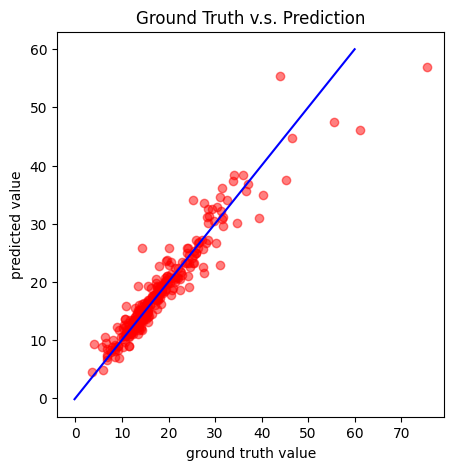

In [270]:
del model
model = RegressionModel(input_size, output_size).to(device)
ckpt = torch.load("/content/model.pth", map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
pred_traget = plot_pred(val_loader, model, device)  # Show prediction on the validation set

In [271]:
ttoc_data = ordinal_cat_transfer(description, position, df_test.copy(), ordinal_col)
ttnoc_data = non_ordinal_cat_transfer(description, position, df_test.copy(), non_ordinal_col)
ttn_data = numerical_transfer(df_test.copy(), ordinal_col, non_ordinal_col)

tt_data = concat_data(ttn_data, ttoc_data, ttnoc_data)
print(tt_data.shape)

tt_set = HOUSEDataset(tt_data, mode = "test")
test_loader = DataLoader(tt_set, batch_size = config["batch_size"])

(1459, 19)
(1459, 188)
(1459, 36)
(1459, 243)
Finished reading the test set of HOUSE Dataset (1459 samples found, each dim = 243)


In [272]:
def test(dataloader, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in dataloader:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    print(preds.shape)
    return preds

preds = test(test_loader, model, device)*10000  # predict COVID-19 cases with your model


(1459, 1)


In [273]:
ind = np.array(range(1461, 2920))
output = pd.DataFrame(np.column_stack((ind, preds)), columns = ["id", "SalePrice"])
output["id"] = output["id"].astype("int32")
output

,id,SalePrice
0,1461,118131.898438
1,1462,168455.656250
2,1463,190584.984375
3,1464,196024.281250
4,1465,191997.343750
...,...,...
1454,2915,82816.125000
1455,2916,75081.695312
1456,2917,182676.156250
1457,2918,119450.031250


In [274]:
output.to_csv("/content/result.csv", index = False)

1. 越深的模型lr要調越小
2. loss func的選擇（MSE超大:38885551398.5753 >> L1 > smoothl1loss > huberloss）
3. 正則化對testing的影響
4. activation func的選擇對loss值的影響
5. 資料處理與標準化
6. loss值的大小代表意義